# Dask Delayed

Dask delayed provides a low level API for building concurrent code.

This notebook provides some examples of how dask delayed can be used to parallelize workflows.

In [42]:
import dask
import time
import requests
import re
import random

Accessing network resources are ideal candidates for parallelization because of the request response cycle. 

Suppose we needed to download a bunch of HTML pages and extract all the links from each page. This process may look something like this:

1. Make a web request
2. Parse the response body

## Python Code

In [63]:
link_pattern = re.compile('href="(.*)"')


def get_page(uri: str) -> str:
    """Make a request to the specified and return the HTML.
    
    This function sleeps for a random amount of time to similate some network io.
    
    Args:
        uri: The uri to be requested
        
    Returns:
        An HTML page
    """
    resp = requests.get(uri)
    resp.raise_for_status()
    time.sleep(random.random())
    return resp.text


def parse_links(page: str) -> list:
    """Extract a list of hrefs from the specified page.
    
    Args:
        page: An html page
        
    Returns:
        A list of hrefs
    """
    return link_pattern.findall(page)

In [64]:
%%time
page = get_page('http://localhost:8888')
links = parse_links(page)
links

CPU times: user 8.82 ms, sys: 1.07 ms, total: 9.88 ms
Wall time: 226 ms


Below we run the same process for 5 and then 10 requests. As one may expect the run time will scale linearly.

In [65]:
%%time
links = []
for i in range(5):
    page = get_page('http://localhost:8888')
    links += parse_links(page)

print(len(links), '\n')

35 

CPU times: user 55.3 ms, sys: 3.76 ms, total: 59.1 ms
Wall time: 2.82 s


In [66]:
%%time
links = []
for i in range(10):
    page = get_page('http://localhost:8888')
    links += parse_links(page)

print(len(links), '\n')

70 

CPU times: user 110 ms, sys: 12.1 ms, total: 122 ms
Wall time: 4.9 s


## Dask Code

As mentioned above network io is idea for parallelism. We can parallelize the above functions using dask by wrapping them in the delayed function.

In [67]:
get_page = delayed(get_page)
parse_links = delayed(parse_links)

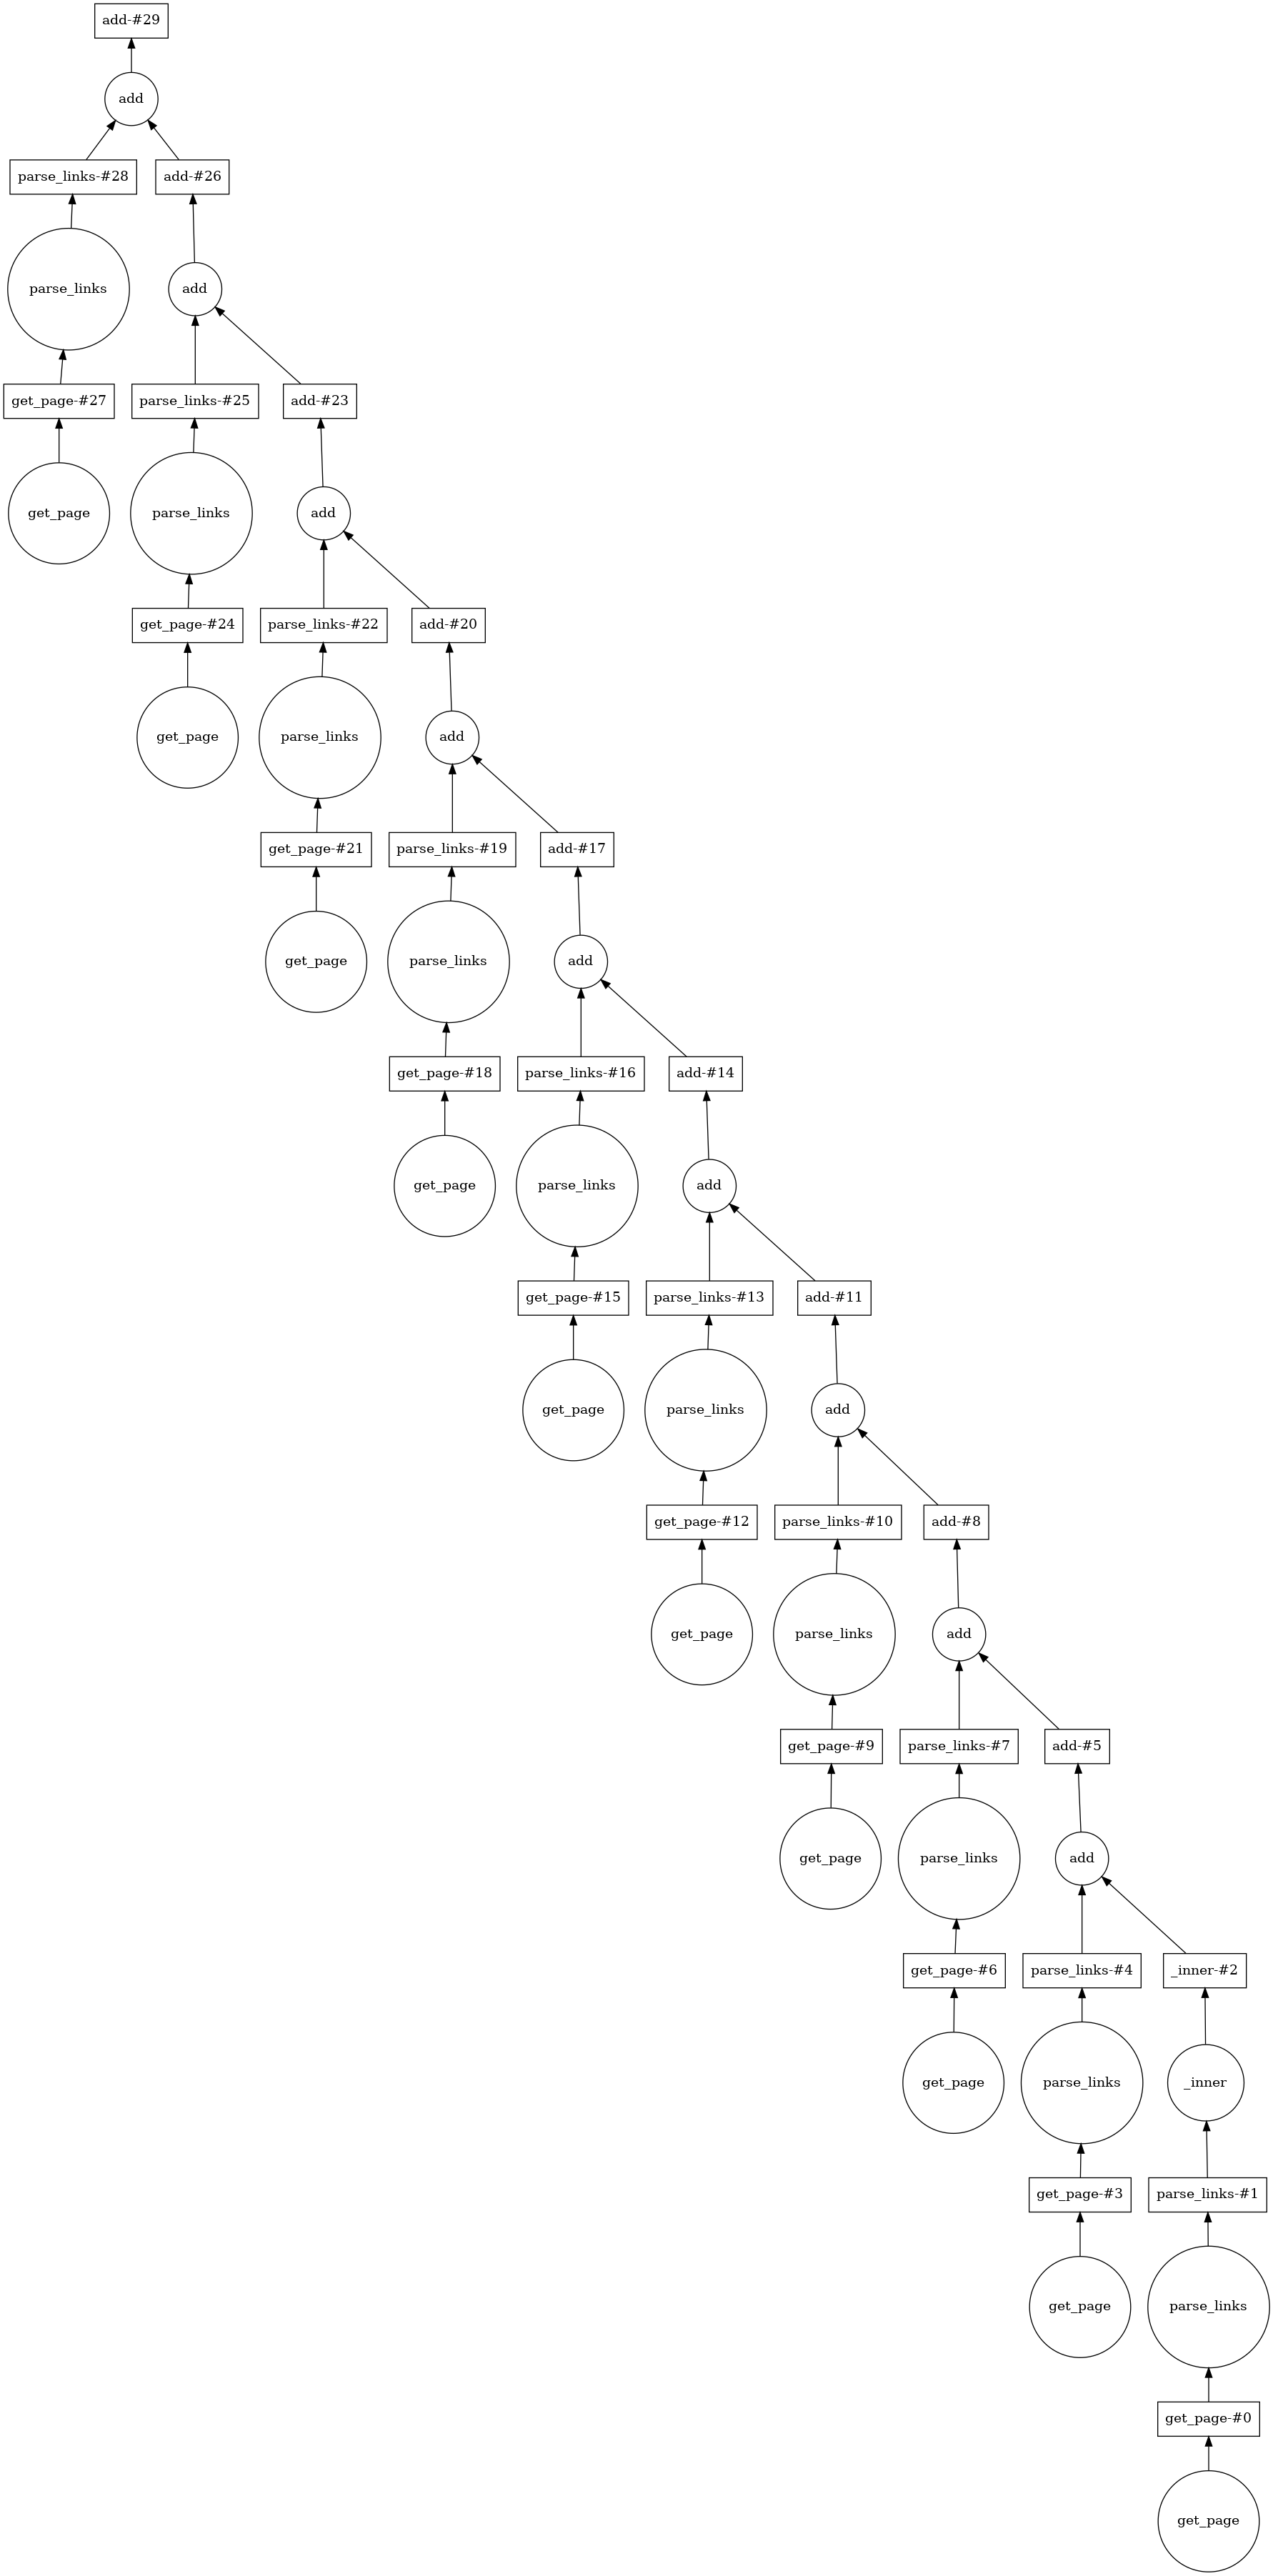

In [68]:
tasks = []
for i in range(10):
    page = get_page('http://localhost:8888')
    tasks += parse_links(page)

visualize(tasks)

As with all the dask APIs no computation will occur until we call compute on the task graph.

In [69]:
%%time
links = compute(tasks)

print(len(*links), '\n')

70 

CPU times: user 115 ms, sys: 6.39 ms, total: 121 ms
Wall time: 1.92 s
